In [1]:
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import spacy
import matplotlib.pyplot as plt

In [2]:
f = open("cwe_mitigation_ids_temp.json")
w_mitigation = json.load(f)

f = open("capec_mitigation_temp.json")
ap_mitigation = json.load(f)

f = open("cwe_temp.json")
cwe = json.load(f)

f = open("capec_temp.json")
capec = json.load(f)

f = open("ap_names.json")
ap_names = json.load(f)

f = open("cwe_names.json")
cwe_names = json.load(f)

with open("w_dict.json", "r") as f:
    w_dict = json.load(f)
with open("ap_dict.json", "r") as f:
    ap_dict = json.load(f)

with open("ap_mitigation_descriptions.json", "r") as f:
    ap_mitigation_descriptions = list(set(json.load(f)))
with open("cwe_mitigation_descriptions.json", "r") as f:
    cwe_mitigation_descriptions = list(set(json.load(f)))

In [3]:
def get_unique_pairs(pairwise_similarities):
    unique_pairs = []
    for i in range(len(pairwise_similarities)):
        for j in range(i + 1, len(pairwise_similarities)):
            unique_pairs.append(pairwise_similarities[i][j])

    return unique_pairs

In [4]:
vectorizer = CountVectorizer()
vectorizer.fit(ap_mitigation_descriptions + cwe_mitigation_descriptions)

ap_mitigation_vectors = vectorizer.transform(ap_mitigation_descriptions)
cwe_mitigation_vectors = vectorizer.transform(cwe_mitigation_descriptions)

ap_similarities_all = cosine_similarity(ap_mitigation_vectors, ap_mitigation_vectors)
among_aps = np.mean(get_unique_pairs(ap_similarities_all))

cwe_similarities_all = cosine_similarity(cwe_mitigation_vectors, cwe_mitigation_vectors)
among_cwes = np.mean(get_unique_pairs(cwe_similarities_all))

cwe_ap_similarities_all = cosine_similarity(
    cwe_mitigation_vectors, ap_mitigation_vectors
)
between_cwes_aps = np.mean(cwe_ap_similarities_all)

print("Among APs ", among_aps)
print("Among CWEs ", among_cwes)
print("Between CWEs and APs ", between_cwes_aps)

Among APs  0.0934644719163671
Among CWEs  0.1563300413956124
Between CWEs and APs  0.11576254620911308


In [5]:
vectorizer = CountVectorizer()
vectorizer.fit(ap_names + cwe_names)

ap_name_vectors = vectorizer.transform(ap_names)
cwe_name_vectors = vectorizer.transform(cwe_names)

ap_name_similarities_all = cosine_similarity(ap_name_vectors, ap_name_vectors)
among_ap_names = np.mean(get_unique_pairs((ap_name_similarities_all)))

ap_cwe_name_similarities_all = cosine_similarity(ap_name_vectors, cwe_name_vectors)
between_cwes_aps_names = np.mean(ap_cwe_name_similarities_all)

print("Among AP names ", among_ap_names)
print("Between CWE and AP names", between_cwes_aps_names)

Among AP names  0.01115952804433786
Between CWE and AP names 0.011774239418148034


In [6]:
def get_unique_pairs_mean(pairwise_similarities):
    unique_pairs = []
    for i in range(len(pairwise_similarities)):
        for j in range(i + 1, len(pairwise_similarities)):
            unique_pairs.append(pairwise_similarities[i][j])

    return np.mean(unique_pairs)

In [7]:
top_25_cwes = [
    "79",
    "787",
    "20",
    "125",
    "119",
    "89",
    "200",
    "416",
    "352",
    "78",
    "190",
    "22",
    "476",
    "287",
    "434",
    "732",
    "94",
    "522",
    "611",
    "798",
    "502",
    "269",
    "400",
    "306",
    "862",
]

bron_to_original_ids = {}

for w in cwe:
    if w["original_id"] in top_25_cwes:
        bron_to_original_ids[w["_id"]] = w["original_id"]

In [8]:
top_25_cwe_mitigation_similarities = {}
ap_similarities_top_25 = []
cwe_similarities_top_25 = []
cwe_ap_similarities_top_25 = []
ap_name_similarities_top_25 = []
ap_cwe_name_similarities_top_25 = []

for cwe_id in bron_to_original_ids:
    cwe_mitigations = set()
    for cwe_mitigation in w_dict[cwe_id]["mitigations"]:
        for cwe_mit in w_mitigation:
            if cwe_mitigation == cwe_mit["_id"]:
                cwe_mitigations.add(cwe_mit["metadata"]["Description"])

    ap_mitigations = set()
    cur_ap_names = []
    for ap in w_dict[cwe_id]["ap"]:
        for capec_mitigation in ap_dict[ap]["mitigations"]:
            for ap_mit in ap_mitigation:
                if capec_mitigation == ap_mit["_id"]:
                    ap_mitigations.add(ap_mit["metadata"])
        cur_ap_names.append(ap_dict[ap]["name"])

    cwe_mitigations = list(cwe_mitigations)
    ap_mitigations = list(ap_mitigations)
    vectorizer = CountVectorizer()
    vectorizer.fit(cwe_mitigations + ap_mitigations)

    among_aps = float("nan")
    among_cwes = float("nan")
    between_cwes_aps = float("nan")

    if ap_mitigations:
        ap_mitigation_vectors = vectorizer.transform(ap_mitigations)
        ap_similarities = cosine_similarity(
            ap_mitigation_vectors, ap_mitigation_vectors
        )
        ap_similarities_top_25.extend(get_unique_pairs(ap_similarities))
        among_aps = get_unique_pairs_mean(ap_similarities)

    if cwe_mitigations:
        cwe_mitigation_vectors = vectorizer.transform(cwe_mitigations)
        cwe_similarities = cosine_similarity(
            cwe_mitigation_vectors, cwe_mitigation_vectors
        )
        cwe_similarities_top_25.extend(get_unique_pairs(cwe_similarities))
        among_cwes = get_unique_pairs_mean(cwe_similarities)

    if cwe_mitigations and ap_mitigations:
        cwe_ap_similarities = cosine_similarity(
            cwe_mitigation_vectors, ap_mitigation_vectors
        )
        cwe_ap_similarities_top_25.extend(cwe_ap_similarities.flatten())
        between_cwes_aps = np.mean(cwe_ap_similarities)

    vectorizer = CountVectorizer()
    vectorizer.fit(cur_ap_names + [w_dict[cwe_id]["name"]])

    if cur_ap_names:
        ap_name_vectors = vectorizer.transform(cur_ap_names)
        ap_name_similarities = cosine_similarity(ap_name_vectors, ap_name_vectors)
        among_ap_names = get_unique_pairs_mean(ap_name_similarities)
        ap_name_similarities_top_25.extend(get_unique_pairs(ap_name_similarities))
        cwe_name_vector = vectorizer.transform([w_dict[cwe_id]["name"]])
        cwe_ap_name_similarities = cosine_similarity(ap_name_vectors, cwe_name_vector)
        ap_cwe_name_similarities_top_25.extend(cwe_ap_name_similarities.flatten())
        between_cwe_ap_names = np.mean(cwe_ap_name_similarities)

    top_25_cwe_mitigation_similarities[bron_to_original_ids[cwe_id]] = {
        "name": w_dict[cwe_id]["name"],
        "Among APs": among_aps,
        "Among CWEs": among_cwes,
        "Between CWEs and APs": between_cwes_aps,
        "Among AP names": among_ap_names,
        "Between CWE and AP names": between_cwe_ap_names,
    }

/home/ubuntu/venv_BRON_ML/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/venv_BRON_ML/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
top_25_cwe_mitigation_similarities = pd.DataFrame(top_25_cwe_mitigation_similarities).T

In [10]:
top_25_cwe_mitigation_similarities.mean()

Series([], dtype: float64)

In [11]:
top_25_cwe_mitigation_similarities["cwe id"] = top_25_cwe_mitigation_similarities.index
top_25_cwe_mitigation_similarities = top_25_cwe_mitigation_similarities[
    [
        "cwe id",
        "name",
        "Among APs",
        "Among CWEs",
        "Between CWEs and APs",
        "Among AP names",
        "Between CWE and AP names",
    ]
]
top_25_cwe_mitigation_similarities
top_25_cwe_mitigation_similarities.style.hide_index()

cwe id,name,Among APs,Among CWEs,Between CWEs and APs,Among AP names,Between CWE and AP names
119,Improper Restriction of Operations within the Bounds of a Memory Buffer,0.115263,0.267493,0.139495,0.253960,0.088778
125,Out-of-bounds Read,nan,0.114493,nan,nan,0.000000
190,Integer Overflow or Wraparound,0.099355,0.264664,0.143784,nan,0.577350
20,Improper Input Validation,0.130990,0.309180,0.187939,0.048580,0.027510
200,Exposure of Sensitive Information to an Unauthorized Actor,0.098117,nan,0.206580,0.061717,0.003460
22,Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal'),0.144097,0.377541,0.195878,0.184396,0.140560
269,Improper Privilege Management,0.086833,0.311411,0.128370,0.438832,0.383277
287,Improper Authentication,0.076365,nan,0.108220,0.041580,0.100000
306,Missing Authentication for Critical Function,0.304705,0.342175,0.305751,0.000000,0.000000
352,Cross-Site Request Forgery (CSRF),0.283831,0.261373,0.271493,0.186004,0.408608


In [12]:
model = SentenceTransformer("all-mpnet-base-v2")

cwe_embeddings = model.encode(cwe_mitigation_descriptions)
ap_embeddings = model.encode(ap_mitigation_descriptions)

ap_similarities_all = util.cos_sim(ap_embeddings, ap_embeddings)
among_aps = get_unique_pairs_mean(ap_similarities_all)

cwe_similarities_all = util.cos_sim(cwe_embeddings, cwe_embeddings)
among_cwes = get_unique_pairs_mean(cwe_similarities_all)

cwe_ap_similarities_all = util.cos_sim(ap_embeddings, cwe_embeddings)
among_cwes_aps = torch.mean(cwe_ap_similarities_all).item()

ap_name_vectors = model.encode(ap_names)
cwe_name_vectors = model.encode(cwe_names)

ap_name_similarities_all = util.cos_sim(ap_name_vectors, ap_name_vectors)
among_ap_names = get_unique_pairs_mean(ap_name_similarities_all)

ap_cwe_name_similarities_all = util.cos_sim(ap_name_vectors, cwe_name_vectors)
between_cwes_aps_names = torch.mean(ap_cwe_name_similarities_all).item()

print("Among AP names ", among_ap_names)
print("Between CWE and AP names", between_cwes_aps_names)

print("Among APs ", among_aps)
print("Among CWEs ", among_cwes)
print("Between CWEs and APs ", among_cwes_aps)

Among AP names  0.12046472
Between CWE and AP names 0.08258062601089478
Among APs  0.19600216
Among CWEs  0.19770257
Between CWEs and APs  0.1820322871208191


In [13]:
top_25_cwe_mitigation_similarities = {}
ap_similarities_top_25 = []
cwe_similarities_top_25 = []
cwe_ap_similarities_top_25 = []
ap_cwe_name_similarities_top_25 = []
ap_name_similarities_top_25 = []

for cwe_id in bron_to_original_ids:
    cwe_mitigations = set()
    for cwe_mitigation in w_dict[cwe_id]["mitigations"]:
        for cwe_mit in w_mitigation:
            if cwe_mitigation == cwe_mit["_id"]:
                cwe_mitigations.add(cwe_mit["metadata"]["Description"])

    ap_mitigations = set()
    cur_ap_names = []
    for ap in w_dict[cwe_id]["ap"]:
        for capec_mitigation in ap_dict[ap]["mitigations"]:
            for ap_mit in ap_mitigation:
                if capec_mitigation == ap_mit["_id"]:
                    ap_mitigations.add(ap_mit["metadata"])
        cur_ap_names.append(ap_dict[ap]["name"])

    among_aps = float("nan")
    among_cwes = float("nan")
    between_cwes_aps = float("nan")

    cwe_mitigations = list(cwe_mitigations)
    ap_mitigations = list(ap_mitigations)

    cwe_embeddings = model.encode(cwe_mitigations)
    ap_embeddings = model.encode(ap_mitigations)

    if ap_mitigations:
        ap_similarities = util.cos_sim(ap_embeddings, ap_embeddings)
        among_aps = get_unique_pairs_mean(ap_similarities)
        ap_similarities_top_25.extend(get_unique_pairs(ap_similarities))

    if cwe_mitigations:
        cwe_similarities = util.cos_sim(cwe_embeddings, cwe_embeddings)
        among_cwes = get_unique_pairs_mean(cwe_similarities)
        cwe_similarities_top_25.extend(get_unique_pairs(cwe_similarities))

    if cwe_mitigations and ap_mitigations:
        cwe_ap_similarities = util.cos_sim(ap_embeddings, cwe_embeddings)
        between_cwes_aps = torch.mean(cwe_ap_similarities).item()
        cwe_ap_similarities_top_25.extend(cwe_ap_similarities.flatten())

    if cur_ap_names:
        ap_name_vectors = model.encode(cur_ap_names)
        ap_name_similarities = util.cos_sim(ap_name_vectors, ap_name_vectors)
        among_ap_names = get_unique_pairs_mean(ap_name_similarities)
        ap_name_similarities_top_25.extend(get_unique_pairs(ap_name_similarities))

        cwe_name_vector = model.encode(w_dict[cwe_id]["name"])
        cwe_ap_name_similarities = util.cos_sim(ap_name_vectors, cwe_name_vector)
        ap_cwe_name_similarities_top_25.extend(cwe_ap_name_similarities.flatten())
        between_cwe_ap_names = torch.mean(cwe_ap_name_similarities).item()

    top_25_cwe_mitigation_similarities[bron_to_original_ids[cwe_id]] = {
        "name": w_dict[cwe_id]["name"],
        "Among APs": among_aps,
        "Among CWEs": among_cwes,
        "Between CWEs and APs": between_cwes_aps,
        "Among AP names": among_ap_names,
        "Between CWE and AP names": between_cwe_ap_names,
    }

In [14]:
top_25_cwe_mitigation_similarities = pd.DataFrame(top_25_cwe_mitigation_similarities).T

In [15]:
top_25_cwe_mitigation_similarities.mean()

Series([], dtype: float64)

In [16]:
top_25_cwe_mitigation_similarities["cwe id"] = top_25_cwe_mitigation_similarities.index
top_25_cwe_mitigation_similarities = top_25_cwe_mitigation_similarities[
    [
        "cwe id",
        "name",
        "Among APs",
        "Among CWEs",
        "Between CWEs and APs",
        "Among AP names",
        "Between CWE and AP names",
    ]
]
top_25_cwe_mitigation_similarities
top_25_cwe_mitigation_similarities.style.hide_index()

cwe id,name,Among APs,Among CWEs,Between CWEs and APs,Among AP names,Between CWE and AP names
119,Improper Restriction of Operations within the Bounds of a Memory Buffer,0.241287,0.416442,0.273956,0.389568,0.428320
125,Out-of-bounds Read,nan,0.267841,nan,nan,0.496448
190,Integer Overflow or Wraparound,0.319081,0.428997,0.357306,nan,0.854027
20,Improper Input Validation,0.239936,0.374335,0.272639,0.193484,0.174702
200,Exposure of Sensitive Information to an Unauthorized Actor,0.253614,nan,0.321873,0.204915,0.075225
22,Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal'),0.316997,0.348529,0.300298,0.367793,0.313407
269,Improper Privilege Management,0.392639,0.607875,0.448878,0.579413,0.691389
287,Improper Authentication,0.314521,nan,0.402684,0.312071,0.381499
306,Missing Authentication for Critical Function,0.389150,0.421480,0.386857,0.055747,0.123551
352,Cross-Site Request Forgery (CSRF),0.338677,0.312852,0.306291,0.331407,0.453440


In [17]:
encode = spacy.load("en_core_web_lg")

In [18]:
def process_text(text):
    doc = encode(text.lower())
    result = []
    for token in doc:
        if token.is_punct:
            continue
        if token.is_space:
            continue

        result.append(token.text)

    return result

In [19]:
# spaCy similarity

ap_encodings = []
cwe_encodings = []

vectorizer = TfidfVectorizer(tokenizer=process_text)
vectorizer.fit(ap_mitigation_descriptions + cwe_mitigation_descriptions)

idfs = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# print(idfs)

for i in range(len(ap_mitigation_descriptions)):
    desc = ap_mitigation_descriptions[i]
    embedding = encode(" ".join(process_text(desc)))
    weighted_embedding = np.zeros((300,))
    for j in range(len(embedding)):
        weighted_embedding += embedding[j].vector * idfs[embedding[j].text]
        # weighted_embedding += embedding[j].vector
    weighted_embedding /= len(embedding)
    ap_encodings.append(weighted_embedding)

for i in range(len(cwe_mitigation_descriptions)):
    desc = cwe_mitigation_descriptions[i]
    embedding = encode(" ".join(process_text(desc)))
    weighted_embedding = np.zeros((300,))
    for j in range(len(embedding)):
        weighted_embedding += embedding[j].vector * idfs[embedding[j].text]
        # weighted_embedding += embedding[j].vector
    weighted_embedding /= len(embedding)
    cwe_encodings.append(weighted_embedding)

ap_similarities_all = []
cwe_similarities_all = []
cwe_ap_similarities_all = []

for i in range(len(ap_encodings)):
    for j in range(i + 1, len(ap_encodings)):
        ap_similarities_all.append(
            cosine_similarity([ap_encodings[i]], [ap_encodings[j]])[0][0]
        )

for i in range(len(cwe_encodings)):
    for j in range(i + 1, len(cwe_encodings)):
        cwe_similarities_all.append(
            cosine_similarity([cwe_encodings[i]], [cwe_encodings[j]])[0][0]
        )

for i in range(len(ap_encodings)):
    for j in range(len(cwe_encodings)):
        cwe_ap_similarities_all.append(
            cosine_similarity([ap_encodings[i]], [cwe_encodings[j]])[0][0]
        )

/home/ubuntu/venv_BRON_ML/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [20]:
ap_similarities_all_lemma = ap_similarities_all
cwe_similarities_all_lemma = cwe_similarities_all
cwe_ap_similarities_all_lemma = cwe_ap_similarities_all

In [21]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(cwe_similarities_all_lemma, cwe_similarities_all))
print(mannwhitneyu(ap_similarities_all_lemma, ap_similarities_all))
print(mannwhitneyu(cwe_ap_similarities_all_lemma, cwe_ap_similarities_all))

MannwhitneyuResult(statistic=171641162704.5, pvalue=0.4999999989105259)
MannwhitneyuResult(statistic=46387534050.0, pvalue=0.4999999970934227)
MannwhitneyuResult(statistic=357708273664.5, pvalue=0.4999999993718891)


In [22]:
# spaCy similarity

ap_name_encodings = []
cwe_name_encodings = []

vectorizer = TfidfVectorizer(tokenizer=process_text)
vectorizer.fit(ap_names + cwe_names)

idfs = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# print(idfs)
for i in range(len(ap_names)):
    desc = ap_names[i]
    embedding = encode(" ".join(process_text(desc)))
    weighted_embedding = np.zeros((300,))
    for j in range(len(embedding)):
        weighted_embedding += embedding[j].vector * idfs[embedding[j].text]
        # weighted_embedding += embedding[j].vector
    weighted_embedding /= len(embedding)
    ap_name_encodings.append(weighted_embedding)

for i in range(len(cwe_names)):
    desc = cwe_names[i]
    embedding = encode(" ".join(process_text(desc)))
    weighted_embedding = np.zeros((300,))
    for j in range(len(embedding)):
        weighted_embedding += embedding[j].vector * idfs[embedding[j].text]
        # weighted_embedding += embedding[j].vector
    weighted_embedding /= len(embedding)
    cwe_name_encodings.append(weighted_embedding)

ap_cwe_name_similarities_all = []
ap_name_similarities_all = []

for i in range(len(ap_name_encodings)):
    for j in range(i + 1, len(ap_name_encodings)):
        ap_name_similarities_all.append(
            cosine_similarity([ap_name_encodings[i]], [ap_name_encodings[j]])[0][0]
        )

for i in range(len(ap_name_encodings)):
    for j in range(len(cwe_name_encodings)):
        ap_cwe_name_similarities_all.append(
            cosine_similarity([ap_name_encodings[i]], [cwe_name_encodings[j]])[0][0]
        )

/home/ubuntu/venv_BRON_ML/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [23]:
print("Between APs and CWEs ", np.mean(cwe_ap_similarities_all))
print("Among APs ", np.mean(ap_similarities_all))
print("Among CWEs ", np.mean(cwe_similarities_all))

Between APs and CWEs  0.749020262231054
Among APs  0.7241398024191311
Among CWEs  0.786893591745925


In [24]:
top_25_cwe_mitigation_similarities = {}
ap_similarities_top_25 = []
cwe_similarities_top_25 = []
cwe_ap_similarities_top_25 = []
ap_cwe_name_similarities_top_25 = []
ap_name_similarities_top_25 = []

for cwe_id in bron_to_original_ids:
    cwe_mitigations = set()
    for cwe_mitigation in w_dict[cwe_id]["mitigations"]:
        for cwe_mit in w_mitigation:
            if cwe_mitigation == cwe_mit["_id"]:
                cwe_mitigations.add(cwe_mit["metadata"]["Description"])

    ap_mitigations = set()
    cur_ap_names = []
    for ap in w_dict[cwe_id]["ap"]:
        cur_ap_names.append(ap_dict[ap]["name"])
        for capec_mitigation in ap_dict[ap]["mitigations"]:
            for ap_mit in ap_mitigation:
                if capec_mitigation == ap_mit["_id"]:
                    ap_mitigations.add(ap_mit["metadata"])

    cwe_mitigations = list(cwe_mitigations)
    ap_mitigations = list(ap_mitigations)

    among_aps = float("nan")
    among_cwes = float("nan")
    between_cwes_aps = float("nan")

    vectorizer = TfidfVectorizer(tokenizer=process_text)
    vectorizer.fit(cwe_mitigations + ap_mitigations)

    idfs = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

    if ap_mitigations:
        ap_encodings = []
        for i in range(len(ap_mitigations)):
            desc = ap_mitigations[i]
            # embedding = encode(desc)
            embedding = encode(" ".join(process_text(desc)))
            weighted_embedding = np.zeros((300,))
            for j in range(len(embedding)):
                weighted_embedding += embedding[j].vector * idfs[embedding[j].text]
                # weighted_embedding += embedding[j].vector
            weighted_embedding /= len(embedding)
            ap_encodings.append(weighted_embedding)
        among_aps = []
        for i in range(len(ap_encodings)):
            for j in range(i + 1, len(ap_encodings)):
                among_aps.append(
                    cosine_similarity([ap_encodings[i]], [ap_encodings[j]])[0][0]
                )
        ap_similarities_top_25.extend(among_aps)

    if cwe_mitigations:
        among_cwes = []
        cwe_encodings = []
        for i in range(len(cwe_mitigations)):
            desc = cwe_mitigations[i]
            # embedding = encode(desc)
            embedding = encode(" ".join(process_text(desc)))
            weighted_embedding = np.zeros((300,))
            # print(embedding)
            for j in range(len(embedding)):
                # print(embedding[j].text)
                weighted_embedding += embedding[j].vector * idfs[embedding[j].text]
                # weighted_embedding += embedding[j].vector
            weighted_embedding /= len(embedding)
            cwe_encodings.append(weighted_embedding)

        for i in range(len(cwe_encodings)):
            for j in range(i + 1, len(cwe_encodings)):
                among_cwes.append(
                    cosine_similarity([cwe_encodings[i]], [cwe_encodings[j]])[0][0]
                )
        cwe_similarities_top_25.extend(among_cwes)

    if ap_mitigations and cwe_mitigations:
        between_aps_cwes = []
        for i in range(len(ap_encodings)):
            for j in range(len(cwe_encodings)):
                between_aps_cwes.append(
                    cosine_similarity([ap_encodings[i]], [cwe_encodings[j]])[0][0]
                )
        cwe_ap_similarities_top_25.extend(between_aps_cwes)

    if cur_ap_names:
        vectorizer = TfidfVectorizer(tokenizer=process_text)
        vectorizer.fit(cur_ap_names + [w_dict[cwe_id]["name"]])
        idfs = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
        ap_name_encodings = []
        for i in range(len(cur_ap_names)):
            desc = cur_ap_names[i]
            # embedding = encode(desc)
            embedding = encode(" ".join(process_text(desc)))
            weighted_embedding = np.zeros((300,))
            for j in range(len(embedding)):
                weighted_embedding += embedding[j].vector * idfs[embedding[j].text]
                # weighted_embedding += embedding[j].vector
            weighted_embedding /= len(embedding)
            ap_name_encodings.append(weighted_embedding)
        among_ap_names = []
        for i in range(len(ap_name_encodings)):
            for j in range(i + 1, len(ap_name_encodings)):
                among_ap_names.append(
                    cosine_similarity([ap_name_encodings[i]], [ap_name_encodings[j]])[
                        0
                    ][0]
                )
        ap_name_similarities_top_25.extend(among_ap_names)

        between_ap_cwe_names = []
        embedding = encode(" ".join(process_text(w_dict[cwe_id]["name"])))
        weighted_embedding = np.zeros((300,))
        for j in range(len(embedding)):
            weighted_embedding += embedding[j].vector * idfs[embedding[j].text]
            # weighted_embedding += embedding[j].vector
        weighted_embedding /= len(embedding)
        weighted_cwe_embedding = weighted_embedding
        for i in range(len(ap_name_encodings)):
            between_ap_cwe_names.append(
                cosine_similarity([ap_name_encodings[i]], [weighted_cwe_embedding])[0][
                    0
                ]
            )

        ap_cwe_name_similarities_top_25.extend(between_ap_cwe_names)

    top_25_cwe_mitigation_similarities[bron_to_original_ids[cwe_id]] = {
        "name": w_dict[cwe_id]["name"],
        "Among APs": np.mean(among_aps),
        "Among CWEs": np.mean(among_cwes),
        "Between CWEs and APs": np.mean(between_aps_cwes),
    }

top_25_cwe_mitigation_similarities = pd.DataFrame(top_25_cwe_mitigation_similarities).T

/home/ubuntu/venv_BRON_ML/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/ubuntu/venv_BRON_ML/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/ubuntu/venv_BRON_ML/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/ubuntu/venv_BRON_ML/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [25]:
top_25_cwe_mitigation_similarities.mean()

Series([], dtype: float64)

In [26]:
top_25_cwe_mitigation_similarities["cwe id"] = top_25_cwe_mitigation_similarities.index
top_25_cwe_mitigation_similarities = top_25_cwe_mitigation_similarities[
    ["cwe id", "name", "Among APs", "Among CWEs", "Between CWEs and APs"]
]
top_25_cwe_mitigation_similarities
top_25_cwe_mitigation_similarities.style.hide_index()

cwe id,name,Among APs,Among CWEs,Between CWEs and APs
119,Improper Restriction of Operations within the Bounds of a Memory Buffer,0.763770,0.885597,0.819408
125,Out-of-bounds Read,nan,0.853007,0.819408
190,Integer Overflow or Wraparound,0.808028,0.903090,0.843242
20,Improper Input Validation,0.775012,0.918163,0.836278
200,Exposure of Sensitive Information to an Unauthorized Actor,0.755788,nan,0.811187
22,Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal'),0.816879,0.929606,0.858592
269,Improper Privilege Management,0.806867,0.908655,0.860483
287,Improper Authentication,0.758593,nan,0.778637
306,Missing Authentication for Critical Function,0.913935,0.936953,0.918072
352,Cross-Site Request Forgery (CSRF),0.895637,0.867083,0.882475


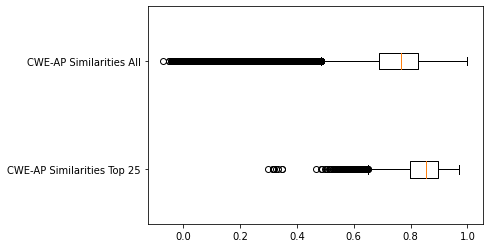

In [27]:
data = {}

cwe_ap_similarities_all = np.array(cwe_ap_similarities_all).flatten()

data["CWE-AP Similarities Top 25"] = cwe_ap_similarities_top_25
data["CWE-AP Similarities All"] = cwe_ap_similarities_all

labels, data = data.keys(), data.values()

plt.boxplot(data, vert=False)
plt.yticks(range(1, len(labels) + 1), labels)
plt.show()

<AxesSubplot:>

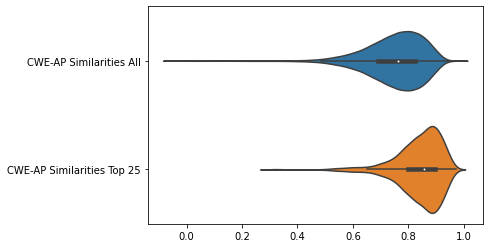

In [28]:
import seaborn as sns

data = {}

data["CWE-AP Similarities Top 25"] = np.array(cwe_ap_similarities_top_25)
data["CWE-AP Similarities All"] = np.array(cwe_ap_similarities_all)

maxsize = max([a.size for a in data.values()])
data_pad = {
    k: np.pad(
        v,
        pad_width=(
            0,
            maxsize - v.size,
        ),
        mode="constant",
        constant_values=np.nan,
    )
    for k, v in data.items()
}
df = pd.DataFrame(data_pad)[["CWE-AP Similarities All", "CWE-AP Similarities Top 25"]]

fig, ax = plt.subplots()
sns.violinplot(data=df, orient="h")

1 1083 (541, 1083)


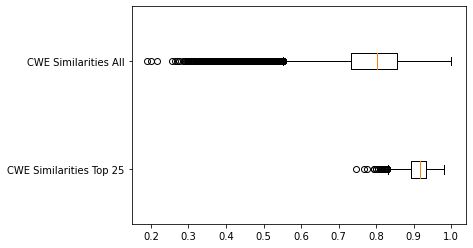

In [29]:
data = {}

# TODO were do I get the values from
temp_cwe = np.array(cwe_similarities_all).reshape(1083, 541).T
print(len(cwe_encodings[0].shape), len(cwe_mitigation_descriptions), temp_cwe.shape)
cwe_similarities_all = get_unique_pairs(temp_cwe)

data["CWE Similarities Top 25"] = cwe_similarities_top_25
data["CWE Similarities All"] = cwe_similarities_all

labels, data = data.keys(), data.values()

plt.boxplot(data, vert=False)
plt.yticks(range(1, len(labels) + 1), labels)
plt.show()

<AxesSubplot:>

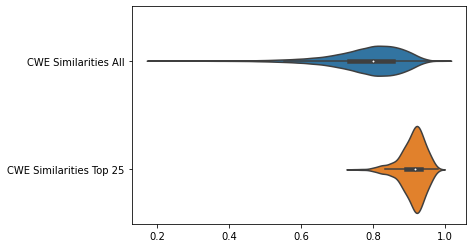

In [30]:
import seaborn as sns

data = {}

data["CWE Similarities Top 25"] = np.array(cwe_similarities_top_25)
data["CWE Similarities All"] = np.array(cwe_similarities_all)

maxsize = max([a.size for a in data.values()])
data_pad = {
    k: np.pad(
        v,
        pad_width=(
            0,
            maxsize - v.size,
        ),
        mode="constant",
        constant_values=np.nan,
    )
    for k, v in data.items()
}
df = pd.DataFrame(data_pad)[["CWE Similarities All", "CWE Similarities Top 25"]]

fig, ax = plt.subplots()
sns.violinplot(data=df, orient="h")

14 (390, 781) (781, 390) 781 390


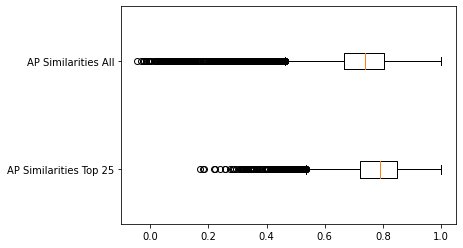

In [31]:
data = {}

n_row = len(ap_mitigation_descriptions)
temp_ap = np.array(ap_similarities_all)
n_col = int(temp_ap.shape[0] / n_row)
temp_ap = temp_ap.reshape(n_row, n_col).T

print(len(ap_encodings), temp_ap.shape, temp_ap.T.shape, n_row, n_col)
ap_similarities_all = get_unique_pairs(temp_ap)

data["AP Similarities Top 25"] = ap_similarities_top_25
data["AP Similarities All"] = ap_similarities_all

labels, data = data.keys(), data.values()

plt.boxplot(data, vert=False)
plt.yticks(range(1, len(labels) + 1), labels)
plt.show()

<AxesSubplot:>

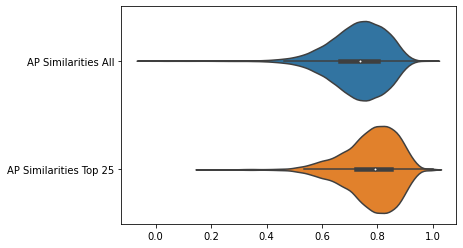

In [32]:
import seaborn as sns

data = {}

data["AP Similarities Top 25"] = np.array(ap_similarities_top_25)
data["AP Similarities All"] = np.array(ap_similarities_all)

maxsize = max([a.size for a in data.values()])
data_pad = {
    k: np.pad(
        v,
        pad_width=(
            0,
            maxsize - v.size,
        ),
        mode="constant",
        constant_values=np.nan,
    )
    for k, v in data.items()
}
df = pd.DataFrame(data_pad)[["AP Similarities All", "AP Similarities Top 25"]]

fig, ax = plt.subplots()
sns.violinplot(data=df, orient="h")

<AxesSubplot:>

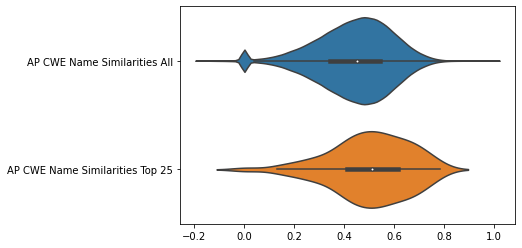

In [33]:
import seaborn as sns

ap_cwe_name_similarities_all = np.array(ap_cwe_name_similarities_all).flatten()

data = {}

data["AP CWE Name Similarities Top 25"] = np.array(ap_cwe_name_similarities_top_25)
data["AP CWE Name Similarities All"] = np.array(ap_cwe_name_similarities_all)

maxsize = max([a.size for a in data.values()])
data_pad = {
    k: np.pad(
        v,
        pad_width=(
            0,
            maxsize - v.size,
        ),
        mode="constant",
        constant_values=np.nan,
    )
    for k, v in data.items()
}
df = pd.DataFrame(data_pad)[
    ["AP CWE Name Similarities All", "AP CWE Name Similarities Top 25"]
]

fig, ax = plt.subplots()
sns.violinplot(data=df, orient="h")

14 (3, 49595) (49595, 3) 3 49595


<AxesSubplot:>

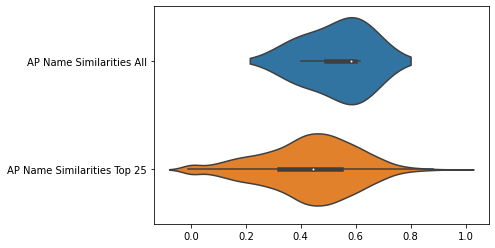

In [34]:
import seaborn as sns

n_row = len(ap_name_encodings)
temp_ap = np.array(ap_name_similarities_all)
n_col = int(temp_ap.shape[0] / n_row)
temp_ap = temp_ap.reshape(n_row, n_col)

print(len(ap_encodings), temp_ap.shape, temp_ap.T.shape, n_row, n_col)

ap_name_similarities_all = get_unique_pairs(temp_ap)

data = {}

data["AP Name Similarities Top 25"] = np.array(ap_name_similarities_top_25)
data["AP Name Similarities All"] = np.array(ap_name_similarities_all)

maxsize = max([a.size for a in data.values()])
data_pad = {
    k: np.pad(
        v,
        pad_width=(
            0,
            maxsize - v.size,
        ),
        mode="constant",
        constant_values=np.nan,
    )
    for k, v in data.items()
}
df = pd.DataFrame(data_pad)[["AP Name Similarities All", "AP Name Similarities Top 25"]]

fig, ax = plt.subplots()
sns.violinplot(data=df, orient="h")

In [35]:
print(np.mean(ap_similarities_top_25))
print(np.mean(cwe_similarities_top_25))
print(np.mean(cwe_ap_similarities_top_25))
print(np.mean(ap_cwe_name_similarities_top_25))
print(np.mean(ap_name_similarities_top_25))

0.7755936210918124
0.9106498592354353
0.8376359882581162
0.5014002702816215
0.4288006617978225


In [36]:
print(np.mean(ap_similarities_all))
print(np.mean(cwe_similarities_all))
print(np.mean(cwe_ap_similarities_all))
# print(torch.mean(cwe_ap_similarities_all).item())
print(np.mean(ap_cwe_name_similarities_all))
# print(torch.mean(ap_cwe_name_similarities_all).item())
print(np.mean(ap_name_similarities_all))

0.7267642577191903
0.7852746826503998
0.749020262231054
0.43478139759935736
0.5321131393396916


In [37]:
print(len(cwe_ap_similarities_top_25))
# print(len(cwe_ap_similarities_all.flatten()))
print(len(cwe_ap_similarities_all))
print(len(cwe_similarities_top_25))
print(len(cwe_similarities_all))
print(len(ap_similarities_top_25))
print(len(ap_similarities_all))

3379
845823
589
146070
14872
75855
